In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import zipfile

extracted_dir = '/content/dataSPLIT20renamed'
zip_file_path = '/content/drive/My Drive/dataSPLIT20renamed.zip'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

Mounted at /content/drive


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
from tensorflow.keras.layers import Flatten

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
from tensorflow.keras.layers import Flatten


train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


train_generator = train_datagen.flow_from_directory(
    '/content/dataSPLIT20renamed/dataSPLIT20renamed/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = valid_datagen.flow_from_directory(
    '/content/dataSPLIT20renamed/dataSPLIT20renamed/valid',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    '/content/dataSPLIT20renamed/dataSPLIT20renamed/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


model1 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model1.trainable = False
x = model1.output
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(20, activation='softmax')(x)

model1 = Model(inputs=model1.input, outputs=predictions)
model1.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9, nesterov=True), loss='categorical_crossentropy', metrics=['accuracy'])

model_path = f'/content/model1res.keras'

callbacks = [
    ModelCheckpoint(
        filepath=model_path,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1,
        mode='max'
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        verbose=1,
        mode='max',
        restore_best_weights=True
    )
]


history1 = model1.fit(
    train_generator,
    callbacks = callbacks,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size
)



Found 2436 images belonging to 20 classes.
Found 531 images belonging to 20 classes.
Found 532 images belonging to 20 classes.
94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/30
76/76 [==============================] - ETA: 0s - loss: 3.1045 - accuracy: 0.4559
Epoch 1: val_accuracy improved from -inf to 0.83594, saving model to /content/model1res.keras
76/76 [==============================] - 44s 383ms/step - loss: 3.1045 - accuracy: 0.4559 - val_loss: 0.5289 - val_accuracy: 0.8359
Epoch 2/30
76/76 [==============================] - ETA: 0s - loss: 0.6912 - accuracy: 0.8057
Epoch 2: val_accuracy improved from 0.83594 to 0.86719, saving model to /content/model1res.keras
76/76 [==============================] - 17s 222ms/step - loss: 0.6912 - accuracy: 0.8057 - val_loss: 0.4577 - val_accuracy: 0.8672
Epoch 3/30
76/76 [==============================] - ETA: 0s - loss: 0.4157 - accuracy: 0.8636
Epoch 3: val_accuracy improved from 0.86719 to 0.88281, saving model to

In [ ]:
from tensorflow.keras.models import load_model

model1_loaded = load_model('/content/model1res.keras')

17/17 [==============================] - 8s 291ms/step


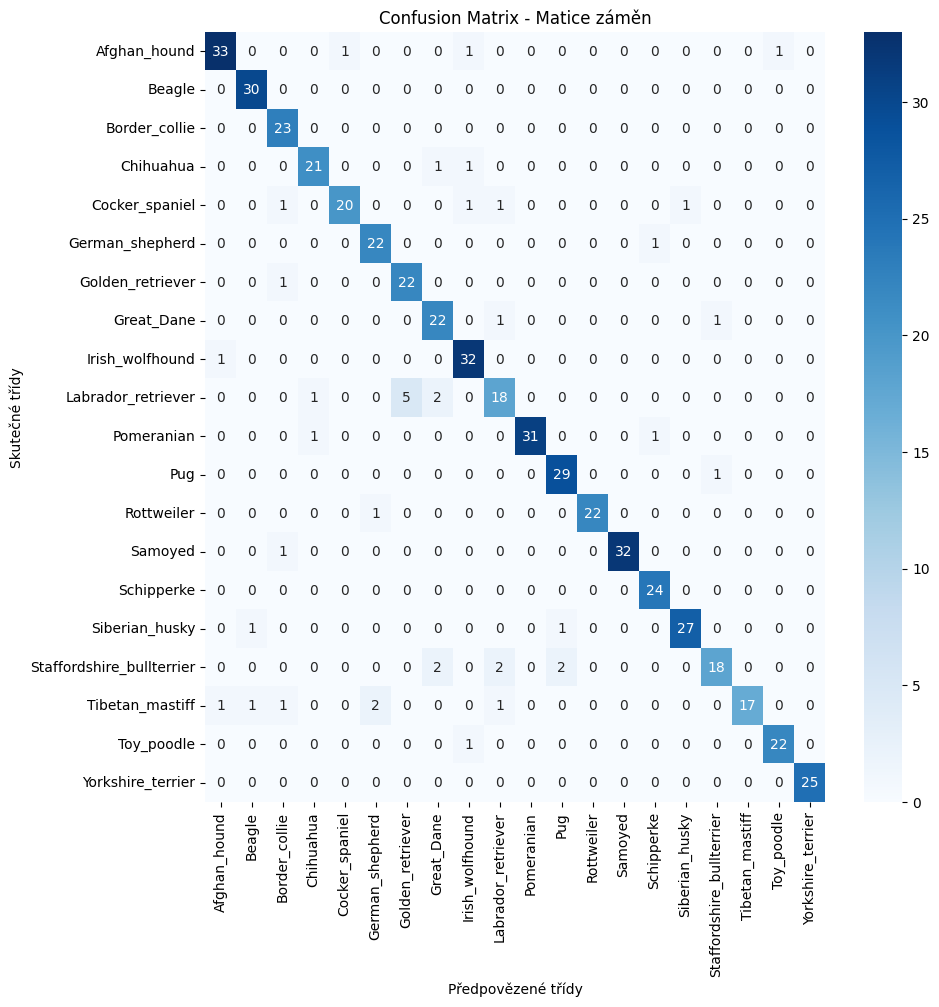

In [ ]:
predictions = model1_loaded.predict(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))
y_pred = np.argmax(predictions, axis=1)

y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Předpovězené třídy')
plt.ylabel('Skutečné třídy')
plt.title('Confusion Matrix - Matice záměn')
plt.show()

17/17 [==============================] - 2s 116ms/step


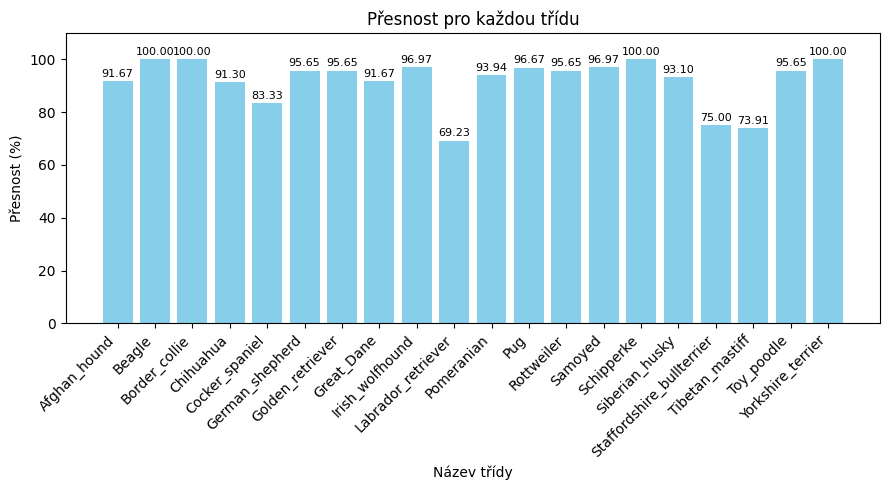

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

test_generator.reset()

validation_steps = np.ceil(test_generator.samples / test_generator.batch_size)

predictions = model1_loaded.predict(test_generator, steps=validation_steps)
y_pred = np.argmax(predictions, axis=1)

y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)

class_accuracy = 100 * np.diag(cm) / np.sum(cm, axis=1)

class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(9, 5))
bars = plt.bar(class_names, class_accuracy, color='skyblue')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval + 1, f"{yval:.2f}", va='bottom', ha='center', fontsize=8)

plt.xlabel('Název třídy')
plt.ylabel('Přesnost (%)')
plt.xticks(rotation=45, ha='right')
plt.title('Přesnost pro každou třídu')
plt.ylim(0, max(class_accuracy) + 10)
plt.tight_layout()
plt.show()


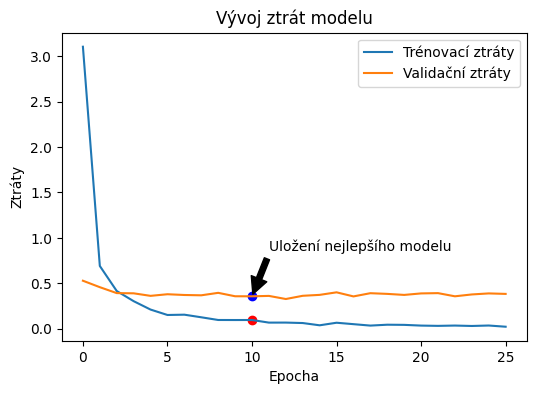

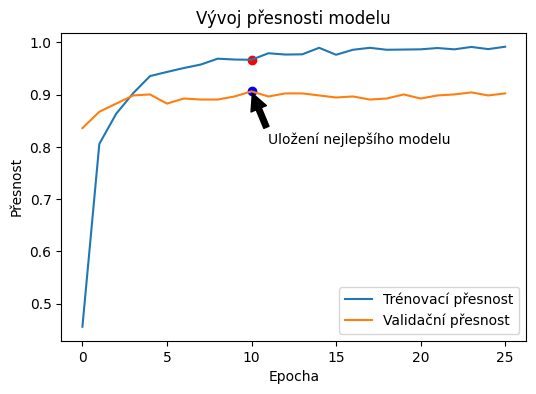

In [ ]:
import matplotlib.pyplot as plt

best_epoch = 10
best_loss = history1.history['loss'][best_epoch]
best_val_loss = history1.history['val_loss'][best_epoch]


plt.figure(figsize=(6, 4))
plt.plot(history1.history['loss'], label='Trénovací ztráty')
plt.plot(history1.history['val_loss'], label='Validační ztráty')
plt.scatter(best_epoch, best_loss, color='red')
plt.scatter(best_epoch, best_val_loss, color='blue')
plt.title('Vývoj ztrát modelu')
plt.ylabel('Ztráty')
plt.xlabel('Epocha')
plt.legend(loc='upper right')

plt.annotate('Uložení nejlepšího modelu', xy=(best_epoch, best_val_loss), xytext=(best_epoch+1, best_val_loss+0.5),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

best_accuracy = history1.history['accuracy'][best_epoch]
best_val_accuracy = history1.history['val_accuracy'][best_epoch]

plt.figure(figsize=(6, 4))
plt.plot(history1.history['accuracy'], label='Trénovací přesnost')
plt.plot(history1.history['val_accuracy'], label='Validační přesnost')
plt.scatter(best_epoch, best_accuracy, color='red')
plt.scatter(best_epoch, best_val_accuracy, color='blue')
plt.title('Vývoj přesnosti modelu')
plt.ylabel('Přesnost')
plt.xlabel('Epocha')
plt.legend(loc='lower right')


plt.annotate('Uložení nejlepšího modelu', xy=(best_epoch, best_val_accuracy), xytext=(best_epoch+1, best_val_accuracy-0.1),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    zoom_range = 0.2,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode='constant'
)


valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    '/content/dataSPLIT20renamed/dataSPLIT20renamed/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
validation_generator = valid_datagen.flow_from_directory(
    '/content/dataSPLIT20renamed/dataSPLIT20renamed/valid',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    '/content/dataSPLIT20renamed/dataSPLIT20renamed/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False
x = base_model.output
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(20, activation='softmax')(x)

model2 = Model(inputs=base_model.input, outputs=predictions)
model2.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9, nesterov=True), loss='categorical_crossentropy', metrics=['accuracy'])

model2_path = f'/content/model2res.keras'

callbacks = [
    ModelCheckpoint(
        filepath=model2_path,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1,
        mode='max'
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        verbose=1,
        mode='max',
        restore_best_weights=True
    )
]


history2 = model2.fit(
    train_generator,
    callbacks = callbacks,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=40,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size
)

Found 2436 images belonging to 20 classes.
Found 531 images belonging to 20 classes.
Found 532 images belonging to 20 classes.
Epoch 1/40
76/76 [==============================] - ETA: 0s - loss: 3.3362 - accuracy: 0.4056
Epoch 1: val_accuracy improved from -inf to 0.83594, saving model to /content/model2res.keras
76/76 [==============================] - 42s 517ms/step - loss: 3.3362 - accuracy: 0.4056 - val_loss: 0.5444 - val_accuracy: 0.8359
Epoch 2/40
76/76 [==============================] - ETA: 0s - loss: 1.0992 - accuracy: 0.6938
Epoch 2: val_accuracy improved from 0.83594 to 0.88867, saving model to /content/model2res.keras
76/76 [==============================] - 39s 518ms/step - loss: 1.0992 - accuracy: 0.6938 - val_loss: 0.3677 - val_accuracy: 0.8887
Epoch 3/40
76/76 [==============================] - ETA: 0s - loss: 0.8136 - accuracy: 0.7700
Epoch 3: val_accuracy improved from 0.88867 to 0.89258, saving model to /content/model2res.keras
76/76 [==============================] 

In [ ]:
from tensorflow.keras.models import load_model

model2_loaded = load_model('/content/model2res.keras')

17/17 [==============================] - 4s 130ms/step


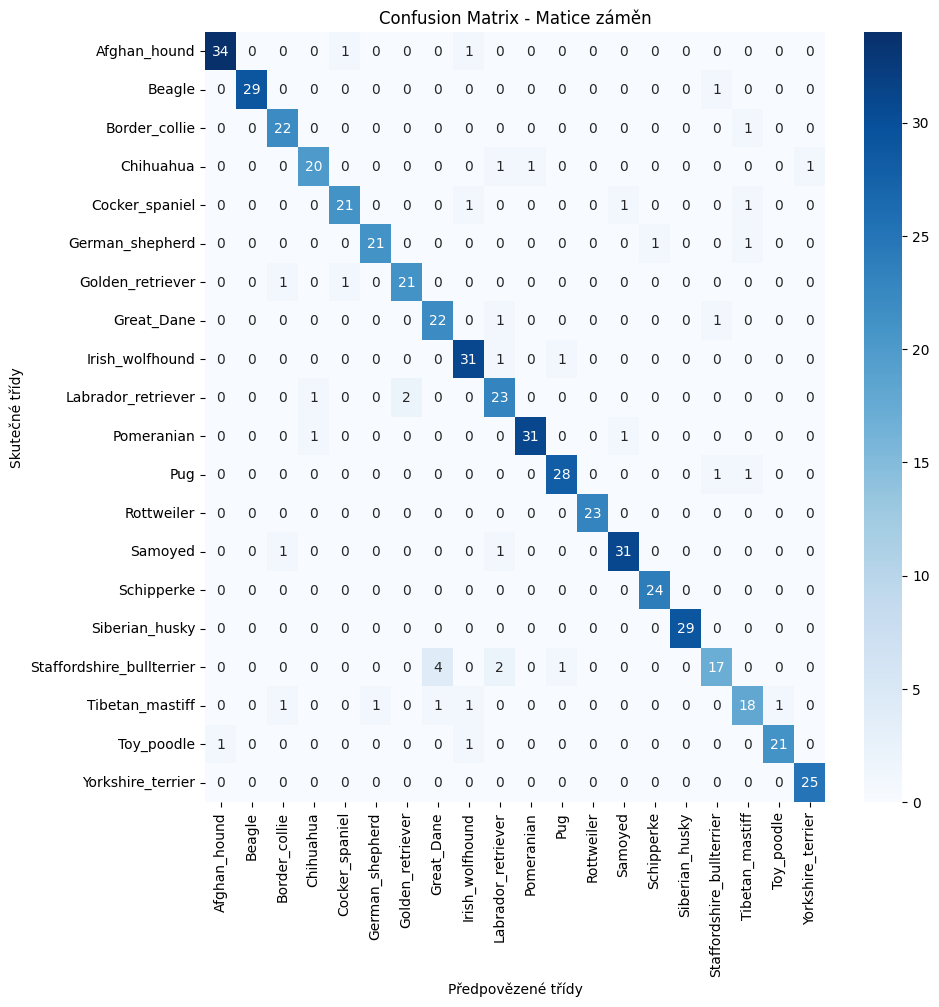

In [ ]:
predictions = model2_loaded.predict(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))
y_pred = np.argmax(predictions, axis=1)

y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Předpovězené třídy')
plt.ylabel('Skutečné třídy')
plt.title('Confusion Matrix - Matice záměn')
plt.show()

17/17 [==============================] - 2s 116ms/step


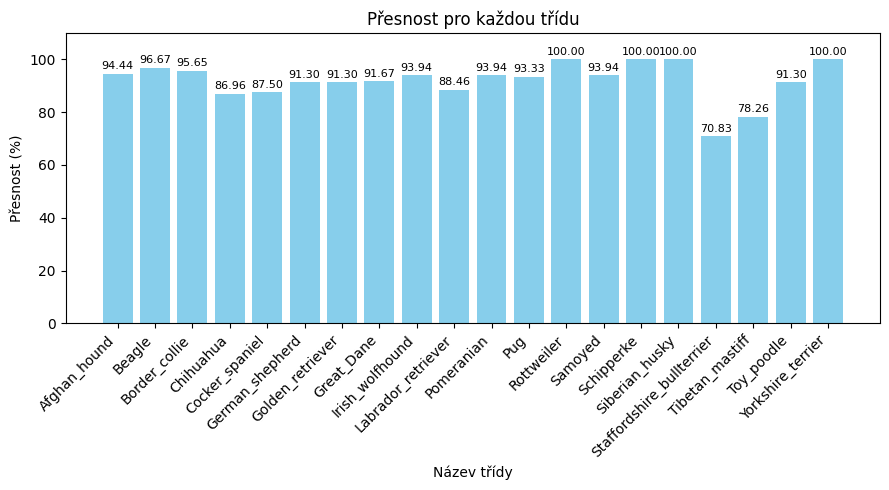

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

test_generator.reset()

validation_steps = np.ceil(test_generator.samples / test_generator.batch_size)

predictions = model2_loaded.predict(test_generator, steps=validation_steps)
y_pred = np.argmax(predictions, axis=1)

y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)

class_accuracy = 100 * np.diag(cm) / np.sum(cm, axis=1)

class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(9, 5))
bars = plt.bar(class_names, class_accuracy, color='skyblue')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval + 1, f"{yval:.2f}", va='bottom', ha='center', fontsize=8)

plt.xlabel('Název třídy')
plt.ylabel('Přesnost (%)')
plt.xticks(rotation=45, ha='right')
plt.title('Přesnost pro každou třídu')
plt.ylim(0, max(class_accuracy) + 10)
plt.tight_layout()
plt.show()

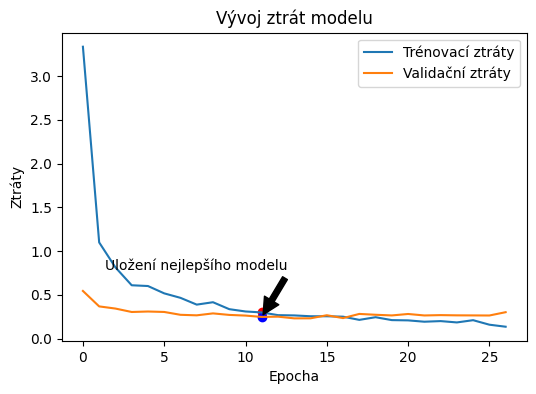

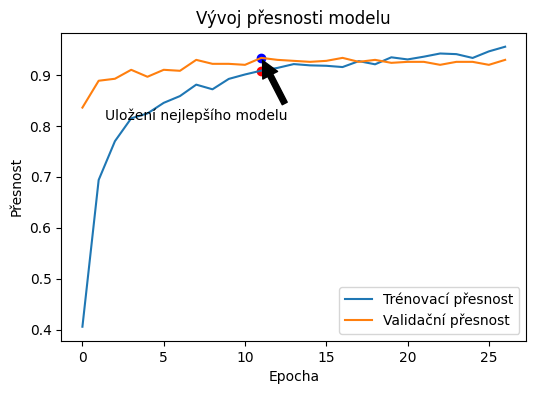

In [ ]:
import matplotlib.pyplot as plt


best_epoch = 11
best_loss = history2.history['loss'][best_epoch]
best_val_loss = history2.history['val_loss'][best_epoch]


plt.figure(figsize=(6, 4))
plt.plot(history2.history['loss'], label='Trénovací ztráty')
plt.plot(history2.history['val_loss'], label='Validační ztráty')
plt.scatter(best_epoch, best_loss, color='red')
plt.scatter(best_epoch, best_val_loss, color='blue')
plt.title('Vývoj ztrát modelu')
plt.ylabel('Ztráty')
plt.xlabel('Epocha')
plt.legend(loc='upper right')


plt.annotate('Uložení nejlepšího modelu', xy=(best_epoch, best_val_loss),
             xytext=(best_epoch-4, best_val_loss+0.5),
             arrowprops=dict(facecolor='black', shrink=0.05),
             ha='center', va='bottom')

plt.show()


best_accuracy = history2.history['accuracy'][best_epoch]
best_val_accuracy = history2.history['val_accuracy'][best_epoch]

plt.figure(figsize=(6, 4))
plt.plot(history2.history['accuracy'], label='Trénovací přesnost')
plt.plot(history2.history['val_accuracy'], label='Validační přesnost')
plt.scatter(best_epoch, best_accuracy, color='red')
plt.scatter(best_epoch, best_val_accuracy, color='blue')
plt.title('Vývoj přesnosti modelu')
plt.ylabel('Přesnost')
plt.xlabel('Epocha')
plt.legend(loc='lower right')


plt.annotate('Uložení nejlepšího modelu', xy=(best_epoch, best_val_accuracy),
             xytext=(best_epoch-4, best_val_accuracy-0.10),
             arrowprops=dict(facecolor='black', shrink=0.05),
             ha='center', va='top')

plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
model3 = tf.keras.models.clone_model(model2_loaded)
model3.set_weights(model2_loaded.get_weights())

In [ ]:
for layer in model3.layers[-53:]:
    print(layer.trainable)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True


In [ ]:
for layer in  model3.layers[-38:]:
    print(layer.name)

conv4_block6_out
conv5_block1_1_conv
conv5_block1_1_bn
conv5_block1_1_relu
conv5_block1_2_conv
conv5_block1_2_bn
conv5_block1_2_relu
conv5_block1_0_conv
conv5_block1_3_conv
conv5_block1_0_bn
conv5_block1_3_bn
conv5_block1_add
conv5_block1_out
conv5_block2_1_conv
conv5_block2_1_bn
conv5_block2_1_relu
conv5_block2_2_conv
conv5_block2_2_bn
conv5_block2_2_relu
conv5_block2_3_conv
conv5_block2_3_bn
conv5_block2_add
conv5_block2_out
conv5_block3_1_conv
conv5_block3_1_bn
conv5_block3_1_relu
conv5_block3_2_conv
conv5_block3_2_bn
conv5_block3_2_relu
conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out
flatten_1
dropout_2
dense_2
dropout_3
dense_3


In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    zoom_range = 0.2,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode='constant'
)


valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    '/content/dataSPLIT20renamed/dataSPLIT20renamed/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
validation_generator = valid_datagen.flow_from_directory(
    '/content/dataSPLIT20renamed/dataSPLIT20renamed/valid',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    '/content/dataSPLIT20renamed/dataSPLIT20renamed/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)




for layer in model3.layers[-15:]:
    layer.trainable = True

model3.compile(optimizer=SGD(learning_rate=0.00001, momentum=0.9, nesterov=True), loss='categorical_crossentropy', metrics=['accuracy'])
model3_path = f'/content/model3res.keras'

callbacks = [
    ModelCheckpoint(
        filepath=model3_path,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1,
        mode='max'
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=30,
        verbose=1,
        mode='max',
        restore_best_weights=True
    )
]

history_finetune = model3.fit(
    train_generator,
    callbacks = callbacks,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size
)

Found 2436 images belonging to 20 classes.
Found 531 images belonging to 20 classes.
Found 532 images belonging to 20 classes.
Epoch 1/100
76/76 [==============================] - ETA: 0s - loss: 0.3318 - accuracy: 0.8898
Epoch 1: val_accuracy improved from -inf to 0.92578, saving model to /content/model3res.keras
76/76 [==============================] - 73s 900ms/step - loss: 0.3318 - accuracy: 0.8898 - val_loss: 0.2554 - val_accuracy: 0.9258
Epoch 2/100
76/76 [==============================] - ETA: 0s - loss: 0.3483 - accuracy: 0.8898
Epoch 2: val_accuracy did not improve from 0.92578
76/76 [==============================] - 35s 456ms/step - loss: 0.3483 - accuracy: 0.8898 - val_loss: 0.2759 - val_accuracy: 0.9160
Epoch 3/100
76/76 [==============================] - ETA: 0s - loss: 0.3071 - accuracy: 0.9089
Epoch 3: val_accuracy did not improve from 0.92578
76/76 [==============================] - 35s 456ms/step - loss: 0.3071 - accuracy: 0.9089 - val_loss: 0.2698 - val_accuracy: 0.9

In [ ]:
from tensorflow.keras.models import load_model

model3_loaded = load_model('/content/model3res.keras')

17/17 [==============================] - 3s 121ms/step


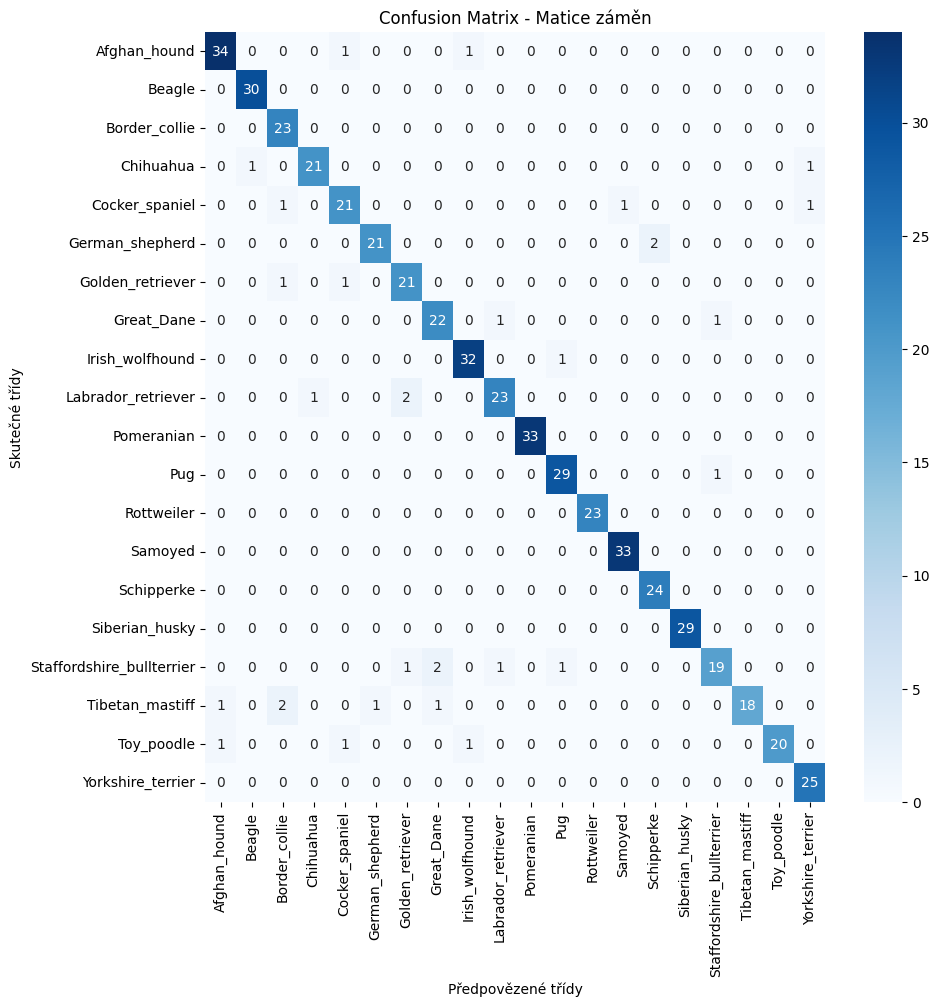

In [ ]:
predictions = model3_loaded.predict(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))
y_pred = np.argmax(predictions, axis=1)

y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Předpovězené třídy')
plt.ylabel('Skutečné třídy')
plt.title('Confusion Matrix - Matice záměn')
plt.show()

17/17 [==============================] - 3s 147ms/step


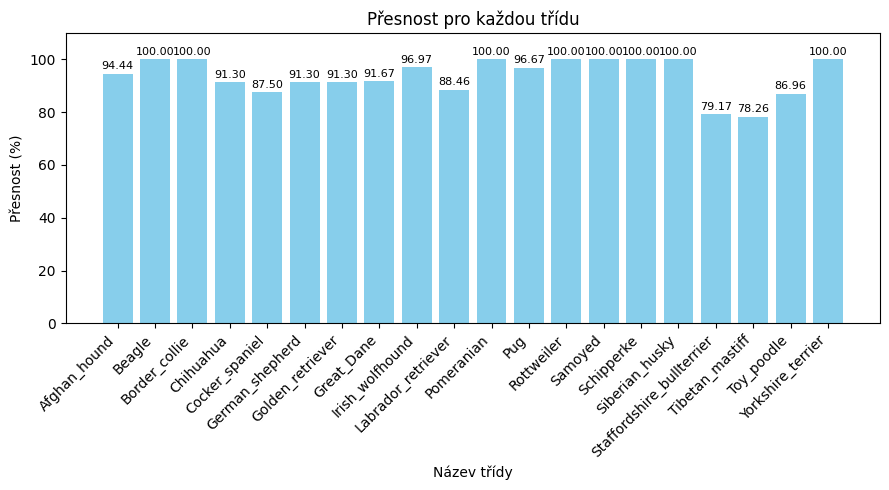

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

test_generator.reset()

validation_steps = np.ceil(test_generator.samples / test_generator.batch_size)

predictions = model3_loaded.predict(test_generator, steps=validation_steps)
y_pred = np.argmax(predictions, axis=1)

y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)

class_accuracy = 100 * np.diag(cm) / np.sum(cm, axis=1)

class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(9, 5))
bars = plt.bar(class_names, class_accuracy, color='skyblue')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval + 1, f"{yval:.2f}", va='bottom', ha='center', fontsize=8)

plt.xlabel('Název třídy')
plt.ylabel('Přesnost (%)')
plt.xticks(rotation=45, ha='right')
plt.title('Přesnost pro každou třídu')
plt.ylim(0, max(class_accuracy) + 10)
plt.tight_layout()
plt.show()

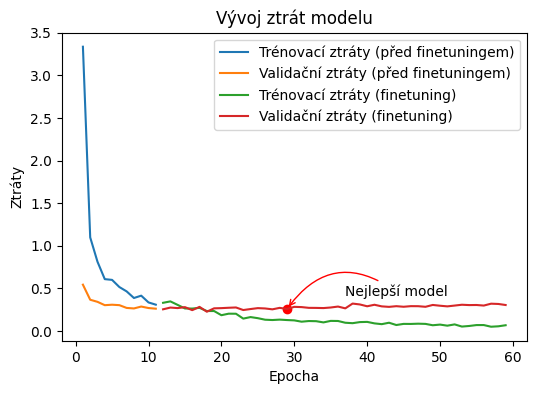

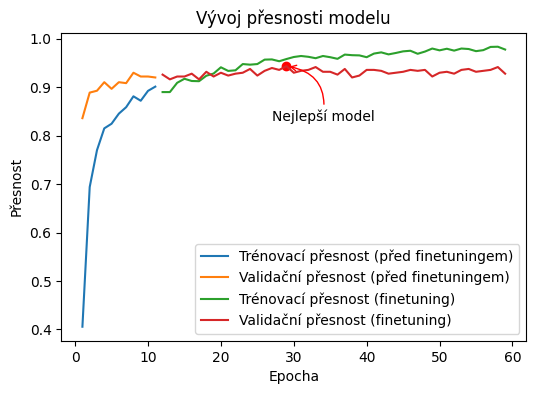

In [ ]:
import matplotlib.pyplot as plt


end_epoch_history2 = 11
epochs_history2 = range(1, end_epoch_history2 + 1)
epochs_history_finetune = range(end_epoch_history2 + 1, end_epoch_history2 + 1 + len(history_finetune.history['accuracy']))


best_finetune_epoch = 29
best_finetune_index = best_finetune_epoch - end_epoch_history2

plt.figure(figsize=(6, 4))
plt.plot(epochs_history2, history2.history['loss'][:end_epoch_history2], label='Trénovací ztráty (před finetuningem)')
plt.plot(epochs_history2, history2.history['val_loss'][:end_epoch_history2], label='Validační ztráty (před finetuningem)')
plt.plot(epochs_history_finetune, history_finetune.history['loss'], label='Trénovací ztráty (finetuning)')
plt.plot(epochs_history_finetune, history_finetune.history['val_loss'], label='Validační ztráty (finetuning)')
plt.scatter(best_finetune_epoch, history_finetune.history['val_loss'][best_finetune_index], color='red')
plt.annotate('Nejlepší model', xy=(best_finetune_epoch, history_finetune.history['val_loss'][best_finetune_index]),
             xytext=(best_finetune_epoch + 15, history_finetune.history['val_loss'][best_finetune_index] + 0.115),
             textcoords="data", ha='center', va='bottom', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.5', color='red'))
plt.title('Vývoj ztrát modelu')
plt.ylabel('Ztráty')
plt.xlabel('Epocha')
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(epochs_history2, history2.history['accuracy'][:end_epoch_history2], label='Trénovací přesnost (před finetuningem)')
plt.plot(epochs_history2, history2.history['val_accuracy'][:end_epoch_history2], label='Validační přesnost (před finetuningem)')
plt.plot(epochs_history_finetune, history_finetune.history['accuracy'], label='Trénovací přesnost (finetuning)')
plt.plot(epochs_history_finetune, history_finetune.history['val_accuracy'], label='Validační přesnost (finetuning)')
plt.scatter(best_finetune_epoch, history_finetune.history['val_accuracy'][best_finetune_index], color='red')
plt.annotate('Nejlepší model', xy=(best_finetune_epoch, history_finetune.history['val_accuracy'][best_finetune_index]),
             xytext=(best_finetune_epoch + 5, history_finetune.history['val_accuracy'][best_finetune_index] - 0.12),
             textcoords="data", ha='center', va='bottom', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.5', color='red'))
plt.title('Vývoj přesnosti modelu')
plt.ylabel('Přesnost')
plt.xlabel('Epocha')
plt.legend(loc='lower right')
plt.show()

17/17 [==============================] - 2s 130ms/step


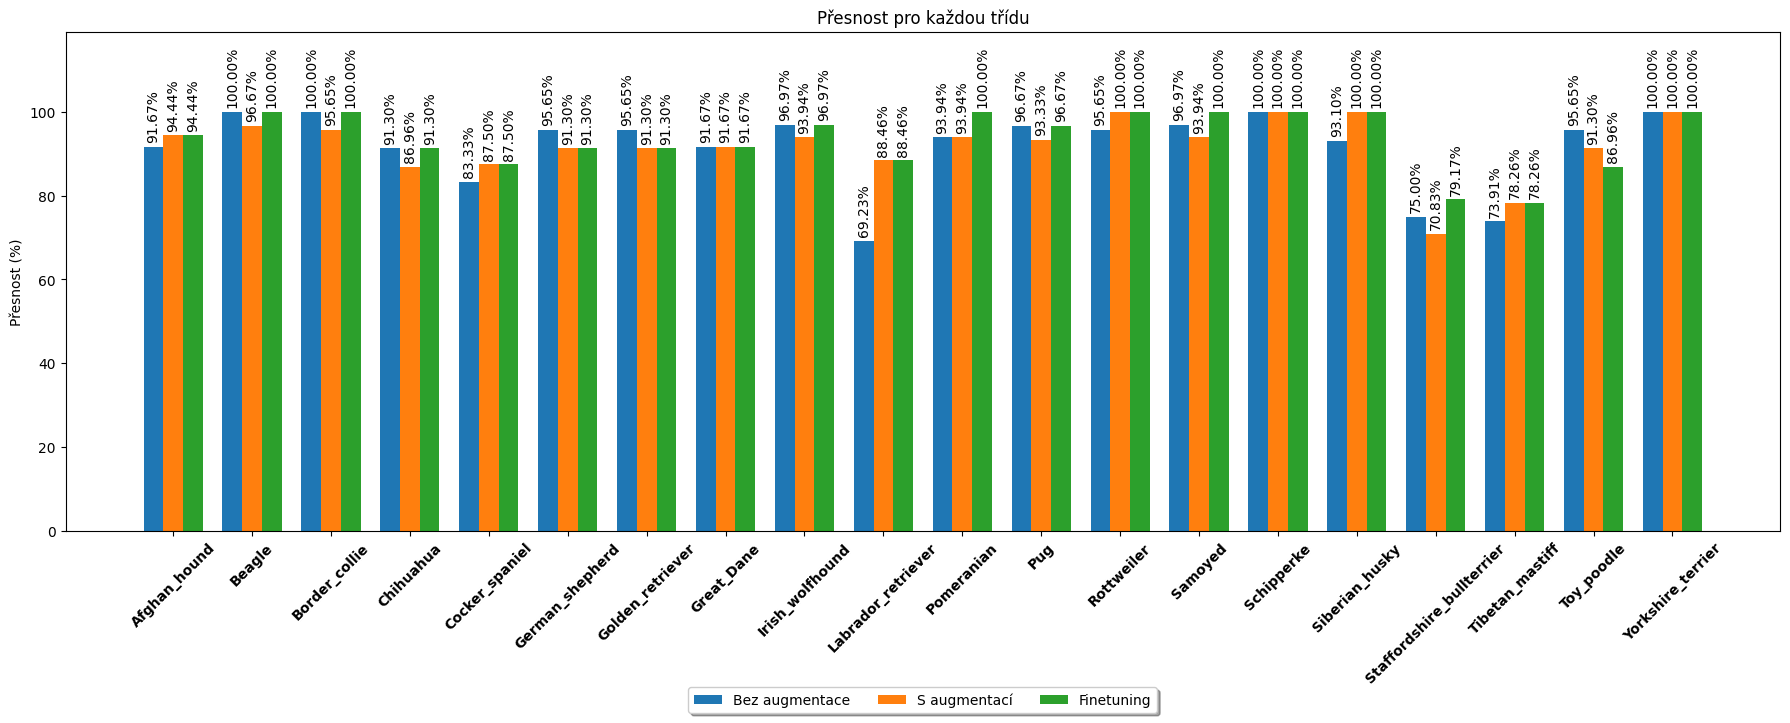

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

predictions1 = model1_loaded.predict(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))
predictions2 = model2_loaded.predict(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))
predictions3 = model3_loaded.predict(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))

y_pred1 = np.argmax(predictions1, axis=1)
y_pred2 = np.argmax(predictions2, axis=1)
y_pred3 = np.argmax(predictions3, axis=1)

y_true = test_generator.classes

cm1 = confusion_matrix(y_true, y_pred1)
cm2 = confusion_matrix(y_true, y_pred2)
cm3 = confusion_matrix(y_true, y_pred3)

accuracy1 = 100 * np.diag(cm1) / np.sum(cm1, axis=1)
accuracy2 = 100 * np.diag(cm2) / np.sum(cm2, axis=1)
accuracy3 = 100 * np.diag(cm3) / np.sum(cm3, axis=1)

class_names = list(test_generator.class_indices.keys())

x = np.arange(len(class_names))
width = 0.25

fig, ax = plt.subplots(figsize=(18, 8))
rects1 = ax.bar(x - width, accuracy1, width, label='Bez augmentace')
rects2 = ax.bar(x, accuracy2, width, label='S augmentací')
rects3 = ax.bar(x + width, accuracy3, width, label='Finetuning')

ax.set_ylabel('Přesnost (%)')
ax.set_title('Přesnost pro každou třídu')
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=45, fontweight='bold')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), shadow=True, ncol=3)
ax.set_ylim(0, max(max(accuracy1), max(accuracy2), max(accuracy3)) + 19)
def autolabel(rects):
    """Připojí popisek nad každý sloupec zobrazující jeho výšku."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    rotation=90)
fig.subplots_adjust(top=1, bottom=0.1)
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.show()


In [ ]:
import os

model_path = '/content/drive/My Drive/FLATTENSGD/'

if not os.path.exists(model_path):
    os.makedirs(model_path)


model1_loaded.save(model_path + 'SGDmodel1_loaded.keras', save_format='tf')
model2_loaded.save(model_path + 'SGDmodel2_loaded.keras', save_format='tf')
model3_loaded.save(model_path + 'SGDmodel3_loaded.keras', save_format='tf')

In [ ]:
# Model 1
train_loss, train_accuracy = model1_loaded.evaluate(train_generator)
print(f"Trénovací ztráta: {train_loss}, Trénovací přesnost: {train_accuracy}")

valid_loss, valid_accuracy = model1_loaded.evaluate(validation_generator)
print(f"Validační ztráta: {valid_loss}, Validační přesnost: {valid_accuracy}")

test_loss, test_accuracy = model1_loaded.evaluate(test_generator)
print(f"Testovací ztráta: {test_loss}, Testovací přesnost: {test_accuracy}")

# Model 2
train_loss2, train_accuracy2 = model2_loaded.evaluate(train_generator)
print(f"Trénovací ztráta modelu 2: {train_loss2}, Trénovací přesnost modelu 2: {train_accuracy2}")

valid_loss2, valid_accuracy2 = model2_loaded.evaluate(validation_generator)
print(f"Validační ztráta modelu 2: {valid_loss2}, Validační přesnost modelu 2: {valid_accuracy2}")

test_loss2, test_accuracy2 = model2_loaded.evaluate(test_generator)
print(f"Testovací ztráta modelu 2: {test_loss2}, Testovací přesnost modelu 2: {test_accuracy2}")

# Model 3
train_loss3, train_accuracy3 = model3_loaded.evaluate(train_generator)
print(f"Trénovací ztráta modelu 3: {train_loss3}, Trénovací přesnost modelu 3: {train_accuracy3}")

valid_loss3, valid_accuracy3 = model3_loaded.evaluate(validation_generator)
print(f"Validační ztráta modelu 3: {valid_loss3}, Validační přesnost modelu 3: {valid_accuracy3}")

test_loss3, test_accuracy3 = model3_loaded.evaluate(test_generator)
print(f"Testovací ztráta modelu 3: {test_loss3}, Testovací přesnost modelu 3: {test_accuracy3}")

77/77 [==============================] - 35s 421ms/step - loss: 0.1414 - accuracy: 0.9577
Trénovací ztráta: 0.14135859906673431, Trénovací přesnost: 0.9577175974845886
17/17 [==============================] - 3s 205ms/step - loss: 0.3630 - accuracy: 0.9040
Validační ztráta: 0.36300230026245117, Validační přesnost: 0.903954803943634
17/17 [==============================] - 2s 114ms/step - loss: 0.2923 - accuracy: 0.9211
Testovací ztráta: 0.2922958433628082, Testovací přesnost: 0.9210526347160339
77/77 [==============================] - 34s 412ms/step - loss: 0.0747 - accuracy: 0.9787
Trénovací ztráta modelu 2: 0.07472062855958939, Trénovací přesnost modelu 2: 0.9786535501480103
17/17 [==============================] - 2s 126ms/step - loss: 0.2457 - accuracy: 0.9322
Validační ztráta modelu 2: 0.24568195641040802, Validační přesnost modelu 2: 0.9322034120559692
17/17 [==============================] - 2s 113ms/step - loss: 0.2629 - accuracy: 0.9229
Testovací ztráta modelu 2: 0.26285842061

In [ ]:
import pandas as pd

data = {
    'Model': ['Bez Augmentace', 'S Augmentací', 'mensiLR'],
    'Trénovací Ztráta': [train_loss, train_loss2, train_loss3],
    'Trénovací Přesnost': [train_accuracy, train_accuracy2, train_accuracy3],
    'Validační Ztráta': [valid_loss, valid_loss2, valid_loss3],
    'Validační Přesnost': [valid_accuracy, valid_accuracy2, valid_accuracy3],
    'Testovací Ztráta': [test_loss, test_loss2, test_loss3],
    'Testovací Přesnost': [test_accuracy, test_accuracy2, test_accuracy3]
}

results_df = pd.DataFrame(data)

print(results_df)

            Model  Trénovací Ztráta  Trénovací Přesnost  Validační Ztráta  \
0  Bez Augmentace          0.141359            0.957718          0.363002   
1    S Augmentací          0.074721            0.978654          0.245682   
2         mensiLR          0.014451            0.995895          0.266476   

   Validační Přesnost  Testovací Ztráta  Testovací Přesnost  
0            0.903955          0.292296            0.921053  
1            0.932203          0.262858            0.922932  
2            0.939736          0.270983            0.941729  


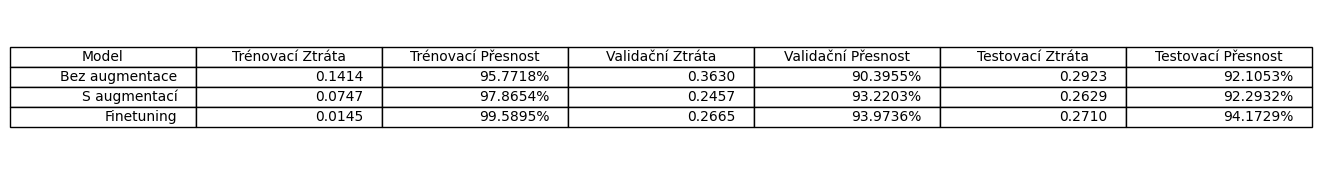

In [ ]:
import matplotlib.pyplot as plt

data = [
    ["Bez augmentace", format(train_loss, ".4f"), format(train_accuracy, ".4%"), format(valid_loss, ".4f"), format(valid_accuracy, ".4%"), format(test_loss, ".4f"), format(test_accuracy, ".4%")],
    ["S augmentací", format(train_loss2, ".4f"), format(train_accuracy2, ".4%"), format(valid_loss2, ".4f"), format(valid_accuracy2, ".4%"), format(test_loss2, ".4f"), format(test_accuracy2, ".4%")],
    ["Finetuning", format(train_loss3, ".4f"), format(train_accuracy3, ".4%"), format(valid_loss3, ".4f"), format(valid_accuracy3, ".4%"), format(test_loss3, ".4f"), format(test_accuracy3, ".4%")]
]

columns = ('Model', 'Trénovací Ztráta', 'Trénovací Přesnost', 'Validační Ztráta', 'Validační Přesnost', 'Testovací Ztráta', 'Testovací Přesnost')

fig, ax = plt.subplots(figsize=(14, 2))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=data, colLabels=columns, loc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

plt.show()